<a href="https://colab.research.google.com/github/gmoraissc/Projetos_de_Data_Science/blob/main/DrugStoreML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTAÇÕES NECESSÁRIAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.model_selection import TimeSeriesSplit, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download rossmann-store-sales
! unzip /content/rossmann-store-sales.zip

stores = pd.read_csv("store.csv")
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
rossmann-store-sales.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/rossmann-store-sales.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace store.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: store.csv               
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


<ipython-input-2-32a9ba8fee08>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("train.csv")


APRESENTANDO OS DADOS

tore.csv - supplemental information about the stores
Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = 
Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
stores.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [ ]:
train_data.head(3)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [ ]:
test_data.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [ ]:
stores.shape, train_data.shape, test_data.shape

((1115, 10), (1017209, 9), (41088, 8))

In [ ]:
stores.columns, train_data.columns, test_data.columns

(Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
       dtype='object'),
 Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday'],
       dtype='object'),
 Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
        'SchoolHoliday'],
       dtype='object'))

In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
percent_missing = stores.apply(lambda x: round(x.isnull().sum() * 100 / len(stores),4) if x.any() > 0 else 0)
missing_value_df = pd.DataFrame({'column_name': stores.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,column_name,percent_missing
Promo2SinceWeek,Promo2SinceWeek,48.7892
Promo2SinceYear,Promo2SinceYear,48.7892
PromoInterval,PromoInterval,48.7892
CompetitionOpenSinceMonth,CompetitionOpenSinceMonth,31.7489
CompetitionOpenSinceYear,CompetitionOpenSinceYear,31.7489
CompetitionDistance,CompetitionDistance,0.2691
Store,Store,0.0000
StoreType,StoreType,0.0000
Assortment,Assortment,0.0000
Promo2,Promo2,0.0000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
percent_missing = train_data.apply(lambda x: round(x.isnull().sum() * 100 / len(train_data),4) if x.any() > 0 else 0)
missing_value_df = pd.DataFrame({'column_name': train_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,column_name,percent_missing
Store,Store,0.0
DayOfWeek,DayOfWeek,0.0
Date,Date,0.0
Sales,Sales,0.0
Customers,Customers,0.0
Open,Open,0.0
Promo,Promo,0.0
StateHoliday,StateHoliday,0.0
SchoolHoliday,SchoolHoliday,0.0


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [ ]:
percent_missing = test_data.apply(lambda x: round(x.isnull().sum() * 100 / len(test_data),4) if x.any() > 0 else 0)
missing_value_df = pd.DataFrame({'column_name': test_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,column_name,percent_missing
Open,Open,0.0268
Id,Id,0.0000
Store,Store,0.0000
DayOfWeek,DayOfWeek,0.0000
Date,Date,0.0000
Promo,Promo,0.0000
StateHoliday,StateHoliday,0.0000
SchoolHoliday,SchoolHoliday,0.0000


As descrições apresentadas nos oferecem as seguintes informações básicas a respeito dos dados com que trabalharemos:

- Possuem alguns dados faltantes (NaN ou Non-null), sob os quais deveremos tratar adequadamente. 
  
  Em especial, devemos tomar cuidado quanto a como proceder com o conjunto de dados "store". Não necessariamente o fato do campo estar vazio significa um erro na coleta - como é o caso de promoções ativas, por exemplo, que não ocorrem sempre e são por tempo determinado em cada loja.
  Há um percentual muito pequeno (0,02%) no dataset de teste - caso este número fosse significativo, deveríamos encontrar uma maneira de inputar este dado faltante através de alguma técnica (média, probabilidade...). Sendo não significativo, podemos apenas realizar o drop das linhas respectivas.

- Possuímos a coluna Date que representa um tipo de dado object, que deverá ser tratado para o formato de data.

- Os dados já foram tratados adequadamente para descrever a presença (1) ou não (0) de alguns fatos, tal como a participação de competidores em promoções.

  Este tipo de informação poderia ter sido coletada através de técnicas de webscrappin, na rede social dos competidores. Ainda, seria necessário tratar os dados de maneira adequada, transformando-os em variáveis dummies ("zeros ou uns"), como foi o caso, para uso dos algortimos - cujos pressupostos não interagem adequadamente com dados categóricos (texto).

- As colunas "SALES" e "COSTUMERS" possuem "tamanhos" diferentes, no sentido de magnitude dos dados. Será preciso analisar a necessidade ou não de transformação destes dados através de técnicas de escalas (https://scikit-learn.org/stable/modules/preprocessing.html#). Isso porque o pressuposto dos modelos linears assumem que os dados precisarem estar centrados em zero ou com uma variação na mesma ordem. "If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."

CONSOLIDANDO OS DADOS

Dado que possuímos uma base de dados de vendas e uma com as informações a respeito das lojas, é preciso consolidar estas informações me um único dataset. 

Esta tarefa é realizada com operações de joins, merges e afins, muito relacionada ao praticado em linguagens de consulta em bancos de dados (SQL, por exemplo).

In [ ]:
merged_sales = train_data.merge(stores, how='left', on="Store", validate="many_to_one")
merged_sales.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


Dado que estamos analisando um conjunto de dados amplo e com variáveis com diferentes magnitues, é uma boa alternativa filtrar aqueles que podem trazer melhores insights.

Um exmeplo é avaliar a assimetria (skew) dos dados:

Skewness is usually described as a measure of a dataset’s symmetry – or lack of symmetry.   A perfectly symmetrical data set will have a skewness of 0.   The normal distribution has a skewness of 0. 

É aconselhado, também, para este tipo de problema, analisar a "curtose" (kurtosis) dos dados:

"The kurtosis parameter is a measure of the combined weight of the tails relative to the rest of the distribution."

Em outras palavras, avalia o quão forte é a "cauda" da distribuição - se mais próxima de zero, menores as caudas e mais próxima de uma distribuição normal estará os dados.

In [ ]:
skewness = merged_sales[['Sales', 'Customers', 'CompetitionDistance']].skew().values
kurtosis = merged_sales[['Sales', 'Customers', 'CompetitionDistance']].kurtosis().values

skew_kurt_df = pd.DataFrame({'COLUMNS': ["Sales", "Customers", "CompetitionDistance"],
                                 'SKEWNESS': skewness,
                                  'KURTOSIS': kurtosis})
skew_kurt_df

,COLUMNS,SKEWNESS,KURTOSIS
0,Sales,0.641460,1.778375
1,Customers,1.598650,7.091773
2,CompetitionDistance,2.928534,13.000022


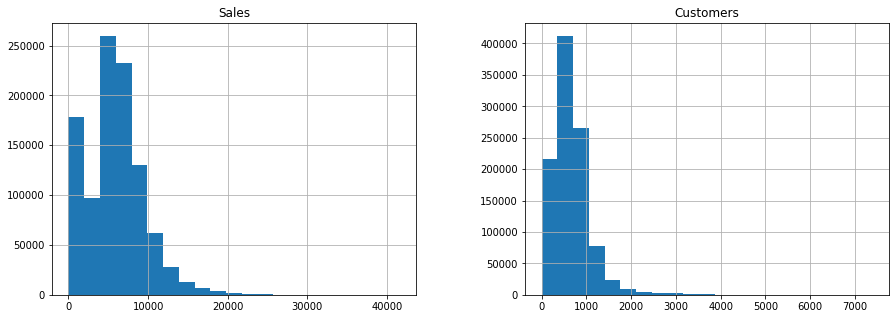

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

merged_sales.hist(column='Sales', bins='sturges', ax=axes[0])
merged_sales.hist(column='Customers', bins='sturges', ax=axes[1])

fig.set_size_inches(15, 5)
plt.show()

O gráfico de histograma é bastante simples e útil de visualmente avaliar estas duas estatísticas. Eles nos demonstram que tanto "SALES" quanto "CUSTOMERS" possuem uma assimetria positiva e uma kurtosis alta.

"If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed

If the skewness is less than -1 or greater than 1, the data are highly skewed"

Avaliando a variável "SALES" com maior detalhe, podemos, através do método describe, entender melhor a sua configuração.

In [ ]:
print(merged_sales['Sales'].describe().round(3)), print("KURTOSIS:", skew_kurt_df[skew_kurt_df['COLUMNS'] == "Sales"]['KURTOSIS'][0]), print("SKEW:", skew_kurt_df[skew_kurt_df['COLUMNS'] == "Sales"]['SKEWNESS'][0])

count    1017209.000
mean        5773.819
std         3849.926
min            0.000
25%         3727.000
50%         5744.000
75%         7856.000
max        41551.000
Name: Sales, dtype: float64
KURTOSIS: 1.7783747472372768
SKEW: 0.6414596158103787


(None, None, None)

Como a média de Vendas é de 5.773, e 50% dos dados possuem valor até 5.744, a maior parte dos "outliers" estarão à direita da média.

Uma curtose alta indica que há alta probailidade de caudas fortes com outliers que podem ser extremos. Considerando os valores mínimos e máximos (0 e 41.551), não é uma surpresa.


O valor máximo muito acima dos valores 5.773 e fora do desvio padrão (std) de 3.849 demonstra por que a média acaba sendo puxada para a direita (no histograma), para uma assimetria (skew) positiva.

LIMPEZA DOS DADOS

Após esta análise prévia, podemos começar a realizar a limpeza dos dados. Em outras palavras, isto significa organizar as informações de acordo com a necessidade do modelo (manipular texto, por exemplo, ou transformar object em date), bem como lidar com dados faltantes.

In [ ]:
merged_sales['Date'] = pd.to_datetime(merged_sales['Date'], format="%Y-%m-%d", errors='raise')

In [ ]:
merged_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [ ]:
print("Linhas antes de realizar o drop dos valores duplicados: " + str(merged_sales.shape[0]))
merged_sales = merged_sales.drop_duplicates()
print("Linhas após realizar o drop dos valores duplicados: " + str(merged_sales.shape[0]))

Linhas antes de realizar o drop dos valores duplicados: 1017209
Linhas após realizar o drop dos valores duplicados: 1017209


In [ ]:
#ajustando input de texto

for col in merged_sales:
    if merged_sales[col].dtype == object:
        merged_sales[col] = merged_sales[col].str.strip()

In [ ]:
#avaliando se o ajuste retorna os valores esperados "object"
for col in merged_sales:
    if merged_sales[col].dtype == object:
        print(merged_sales[col].value_counts())

0    855087
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64
a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64
a    537445
c    471470
b      8294
Name: Assortment, dtype: int64
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64


In [ ]:
check_cols = [ 'Open', 'Promo', 'Promo2', 'SchoolHoliday',  'DayOfWeek', 'CompetitionOpenSinceMonth',  'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

for col in check_cols:
    print(col)
    print(sorted(merged_sales[col].unique()))

Open
[0, 1]
Promo
[0, 1]
Promo2
[0, 1]
SchoolHoliday
[0, 1]
DayOfWeek
[1, 2, 3, 4, 5, 6, 7]
CompetitionOpenSinceMonth
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]
CompetitionOpenSinceYear
[1900.0, 1961.0, 1990.0, 1994.0, 1995.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, nan]
Promo2SinceWeek
[nan, 1.0, 5.0, 6.0, 9.0, 10.0, 13.0, 14.0, 18.0, 22.0, 23.0, 26.0, 27.0, 28.0, 31.0, 35.0, 36.0, 37.0, 39.0, 40.0, 44.0, 45.0, 48.0, 49.0, 50.0]
Promo2SinceYear
[nan, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0]


In [ ]:
merged_sales['CompetitionOpenSinceMonth'] = merged_sales['CompetitionOpenSinceMonth'].convert_dtypes()
merged_sales['CompetitionOpenSinceYear'] = merged_sales['CompetitionOpenSinceYear'].convert_dtypes()
merged_sales['Promo2SinceWeek'] = merged_sales['Promo2SinceWeek'].convert_dtypes()
merged_sales['Promo2SinceYear'] = merged_sales['Promo2SinceYear'].convert_dtypes()

In [ ]:
# apenas a coluna CompetitionDistance deve ser tratada como float (por se tratar de uma distância calculada, portanto valor contínuo)
# enquanto os demais dados devem ser tratados como inteiros pois são representações (verdadeiro/falso, número da loja...)
merged_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               886137 non-null   object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [ ]:
media_total = merged_sales[['Sales', 'Customers']].mean().values
media_loja_aberta = merged_sales.loc[merged_sales['Open'] == 1, ['Sales', 'Customers']].mean().values
media_loja_fechada = merged_sales.loc[merged_sales["Open"] == 0, ['Sales', 'Customers']].mean().values
media_loja_fechada
comparativo_loja_aberta_fechada_df = pd.DataFrame({'COLUMNS': ["Sales", "Customers"],
                                 'MEDIA_TOTAL': media_total,
                                  'LOJA ABETA': media_loja_aberta,
                                  'LOJA FECHADA (COUNT)': media_loja_fechada})
comparativo_loja_aberta_fechada_df

,COLUMNS,MEDIA_TOTAL,LOJA ABETA,LOJA FECHADA (COUNT)
0,Sales,5773.818972,6955.514291,0.0
1,Customers,633.145946,762.728395,0.0


In [ ]:
#Como esperado, não há nos dados quando a loja está fechada valores representando vendas. Podemos realizar o drop.
merged_sales.drop(index=(merged_sales[merged_sales["Open"] == 0]).index, axis=1, inplace=True)
merged_sales.drop(columns=["Open"], inplace=True)

Sales                     AxesSubplot(0.125,0.125;0.227941x0.755)
Customers              AxesSubplot(0.398529,0.125;0.227941x0.755)
CompetitionDistance    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

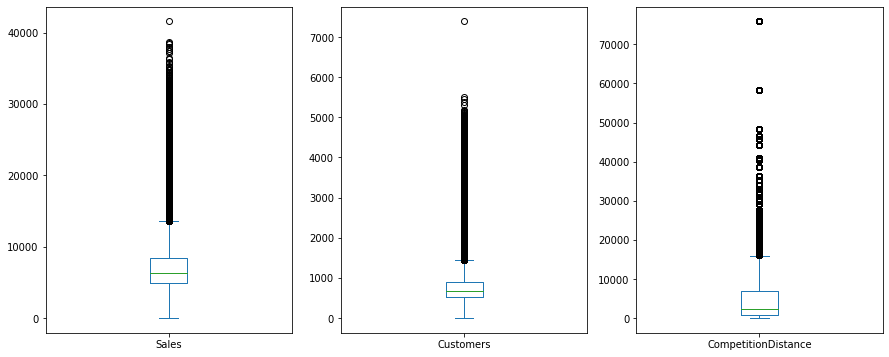

In [ ]:
#Avaliando as variáveis Vendas, Clientes e Distância do competidor, podemos entender melhor posteriores tratamentos.
#A escolha destas se deu pelo fato de que as demais são valores como "verdeiro/falso" ou categóricas (tipo da loja),
#que não trarão insights quanto a outliers.
merged_sales.plot(y=['Sales', 'Customers', 'CompetitionDistance'], 
           kind='box', subplots=True, layout=(1,3), figsize=(15,6))

In [ ]:
#Como demonstra o boxplot acima, precisamos tratar adequadamente os outliers. Faremos o cálculo a partir dos Interquartis.
def calculate_outlier(df,column):
    Q3 = df[column].quantile(0.75)
    Q1 = df[column].quantile(0.25)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    percent_outliers = round(((df[df[column] > upper].shape[0]) + (df[df[column] < lower].shape[0])) / df.shape[0] * 100, 2)
    return lower, upper, percent_outliers

In [ ]:
#O código abaixo demonstra a influência dos outliers na venda média ao longo das variáveis Sales, Customers e CompetitionDistance
d = []
cols = ["Sales", "Customers", "CompetitionDistance"]
for col in cols:
  
  lower_band, upper_band, outliers_perc = calculate_outlier(merged_sales, col)
  
  outliers = merged_sales[merged_sales[col] > upper_band]
  
  d.append(
      {
          "Variable" : col,
          "LowerBand" : lower_band,
          "UpperBand" : upper_band,
          "OutliersPerc" : outliers_perc,
          "SalesMeanTotal": merged_sales["Sales"].mean(),
          "SalesMeanOutliers": outliers["Sales"].mean()
      }
  )
  outliers_per_col = pd.DataFrame(d).sort_values(by="OutliersPerc", ascending=False)

outliers_per_col

#A tabela resume e demonstra que será necessário tratar cada variável adequadamente, em especial com
#Preprocessamento da biblioteca SciKit-Learn para normalização das variáveis com outliers, tratando cada
#caso adequadamente

,Variable,LowerBand,UpperBand,OutliersPerc,SalesMeanTotal,SalesMeanOutliers
2,CompetitionDistance,-8560.0,16160.0,9.83,6955.514291,6827.112294
1,Customers,-42.0,1454.0,4.84,6955.514291,14357.608719
0,Sales,-392.5,13611.5,3.64,6955.514291,16763.942182


In [ ]:
#Para analisarmos os dados com maior profundidade, isto é, 
#entendendo a configuração das vendas nos anos, meses e dias, 
#implementamos a adição de Year (Ano), Month (Mês) e Dia (Day) no dataset.
#Além disso, utilizamos a função week_of_month para entendermos qual semana
#é dentro de cada mês

#Também podemos notar que a data limite (máx) é julho-2015.
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

merged_sales["Year"] = merged_sales["Date"].dt.year
merged_sales["Month"] = merged_sales["Date"].dt.month
merged_sales["DayOfMonth"] = merged_sales["Date"].dt.day
merged_sales["WeekOfMonth"] = merged_sales["Date"].apply(week_of_month)

merged_sales["Date"].describe()

<ipython-input-9-4ada47082d44>:26: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged_sales["Date"].describe()


count                  844392
unique                    942
top       2014-04-16 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

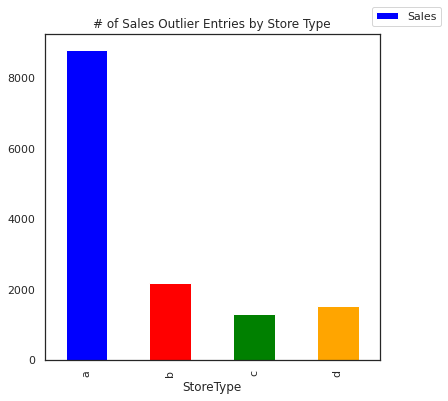

In [ ]:
#O gráfico abaixa demonstra como as vendas na Loja de Tipo "A" possui a maior presença de outliers. 
#Por que isso ocorre? Talvez a variável de Distância ao competidor possa nos oferecer insight sobre isso.

lower_band, upper_band, outliers_perc = calculate_outlier(merged_sales, col)
  
outliers = merged_sales[merged_sales["Sales"] > upper_band]

sales_outliers_by_stype = pd.pivot_table((outliers), index='StoreType', values='Sales', aggfunc='count')

sales_outliers_by_stype.plot(y='Sales', kind='bar', figsize=(6,6), 
                             title="# of Sales Outlier Entries by Store Type", 
                             color=['blue','red','green','orange'])
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()

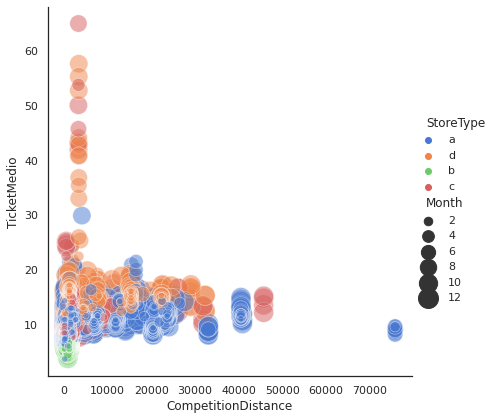

In [ ]:
#O gráfico abaixo separa os dados outliers em cada mês para cada tipo de loja,
#destacando o tamanho do Ticket Médio pelo mês de venda.

#Ele demonstra que existe um perfil de compra diferente em cada store type 
#ao longo dos meses. 

#Podemos confirmar isso através de testes estatísticos, feitos na próxima seção.

sns.set_theme(style="white")

sns.relplot(x="CompetitionDistance", 
            y="TicketMedio", 
            hue="StoreType", 
            size="Month",
            sizes=(40, 400), 
            alpha=.5, 
            palette="muted",
            height=6, 
            data=outliers)

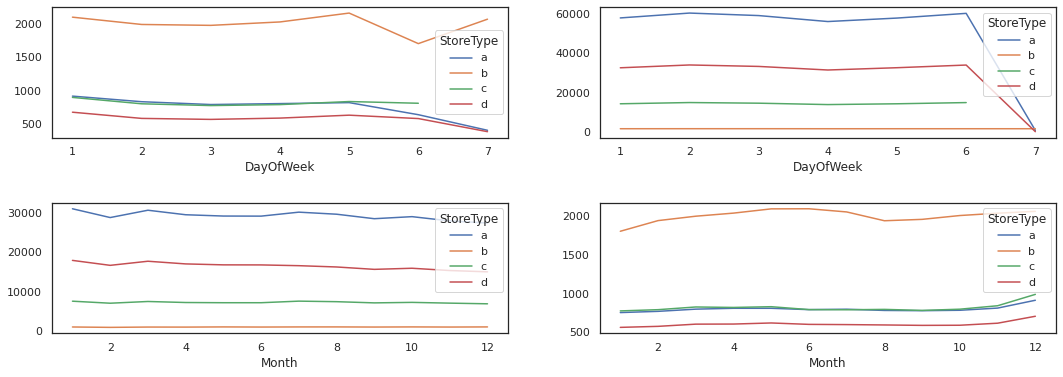

In [ ]:
#Como nossos dados não possuem vendas fechadas após 2014, faremos a análise completa até dez-2014.

stype_pivot_avg_customers_weekday = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                   index='DayOfWeek', 
                                                   values='Customers', 
                                                   columns='StoreType', 
                                                   aggfunc=np.mean)

stype_pivot_avg_customers_month = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                 index='Month', 
                                                 values='Customers', 
                                                 columns='StoreType', 
                                                 aggfunc=np.mean)

stype_pivot_count_customers_month = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                   index='Month', 
                                                   values='Customers', 
                                                   columns='StoreType', 
                                                   aggfunc="count")

stype_pivot_count_customers_weekday = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                     index='DayOfWeek', 
                                                     values='Customers', 
                                                     columns='StoreType', 
                                                     aggfunc="count")

graphs_to_plot = [stype_pivot_avg_customers_weekday,
                  stype_pivot_count_customers_weekday, 
                  stype_pivot_count_customers_month, 
                  stype_pivot_avg_customers_month]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)
axe = axes.ravel()

for i, c in enumerate(graphs_to_plot):
    c.plot(ax=axe[i])

#Os gráficos nos dão um indicativo de como se comportam as vendas 
#por tipo de loja ao longo dos meses e dos diferentes dias da semana

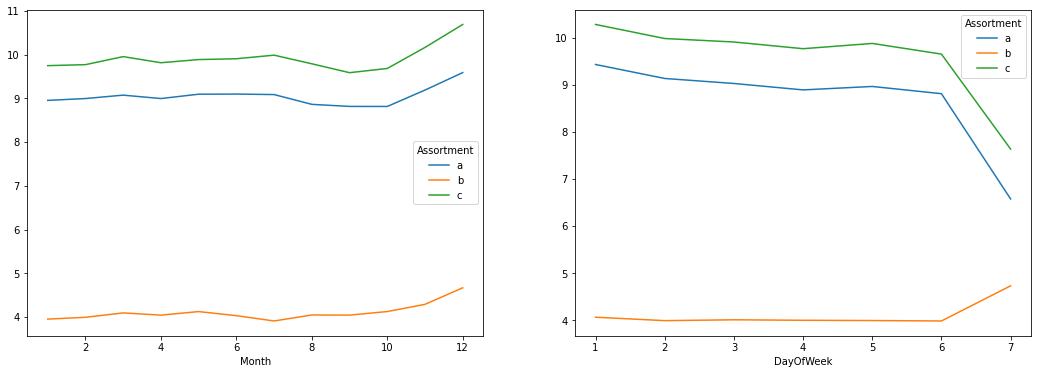

In [ ]:
#De maneira ains mais aprofundada, se pararmos para pensar na prática, qual é o período em que as pessoas,
#no geral, frequentam uma farmácia? Conforme elas recebem seu salário.

#Logo, seria interessante analisarmos o comportamento das vendas no início e final de cada mês, que
#é quando a maior parte dos indivíduos recebem o salário. Abaixo, criamos estas variáveis, e
#analisamos no próximo gráfico.

#Além disso, também pode ser ainda mais interessante do que a configuração por loja,
#entender o tipo de produto (Assortment) que mais se adquire, através do seu ticket-médio.

merged_sales["EndOfMonth"] = merged_sales["Date"].dt.is_month_end
merged_sales["StartOfMonth"] = merged_sales["Date"].dt.is_month_start
merged_sales.replace({True: 1, False: 0}, inplace=True)
merged_sales['TicketMedio'] = merged_sales['Sales'] / merged_sales['Customers']

assortment_pivot_ticket_medio_month = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                     index='Month', 
                                                     values='TicketMedio', 
                                                     columns='Assortment', 
                                                     aggfunc=np.mean)

assortment_pivot_ticket_medio_weekday = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                       index='DayOfWeek', 
                                                       values='TicketMedio', 
                                                       columns='Assortment', 
                                                       aggfunc=np.mean)

graphs_to_plot = [
    assortment_pivot_ticket_medio_month,
    assortment_pivot_ticket_medio_weekday,

]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axe = axes.ravel()

for i, c in enumerate(graphs_to_plot):
    c.plot(ax=axe[i])

#Estes gráficos comparam o Ticket-Médio por Mês e Dia da Semana por tipo de produto.
#Visualmente notamos que a partir do mês 10, há uma crescente.
#Nos dias da semana, sexta (6) e sábado (7) há uma queda nos produtos "a" e "c", e um
#aumento nos produtos tipo "b".

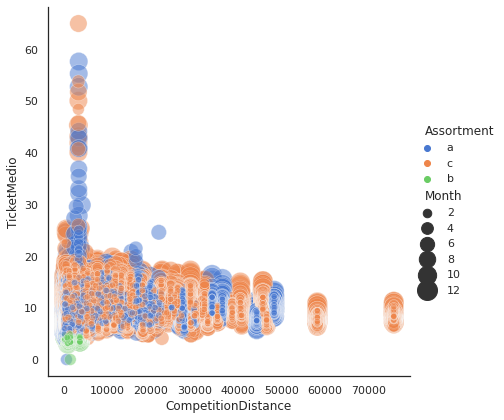

In [ ]:
sns.set_theme(style="white")

sns.relplot(x="CompetitionDistance", 
            y="TicketMedio", 
            hue="Assortment", 
            size="Month",
            sizes=(40, 400), 
            alpha=.5, 
            palette="muted",
            height=6, 
            data=merged_sales)

#Ao analisarmos o volume por mês do ticket-médio por tipo de produto dada a distância ao competidor,
#notamos que os produtos de tipo "b", em verde, parecem estar posicionados mais próximos dos competidores,
#além de terem um ticket-médio menor.
#Já os produtos de tipo a ou c possuem maior variabilidade ao longo dos meses, mas com uma tendência
#de diminuição de acordo com a maior distância até o próximo competidor, o que parece fazer sentido,
#visto que um consumidor muitas vezes optará pela loja mais próxima pelo melhor preço.

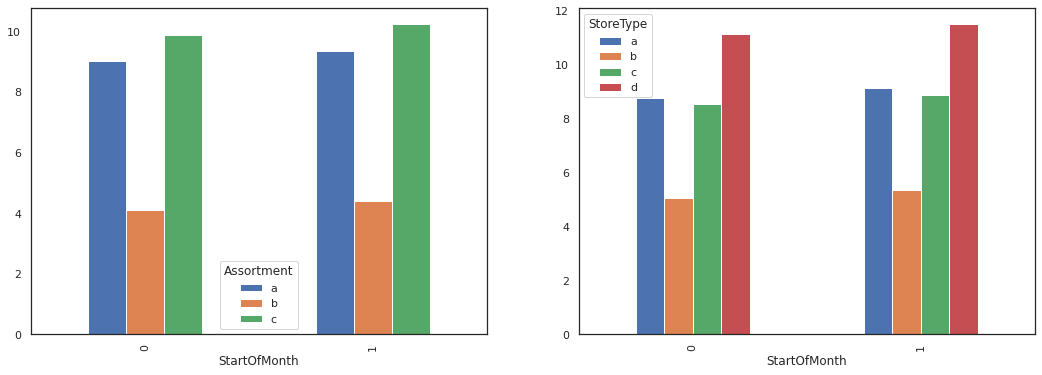

In [ ]:
assortment_pivot_ticketmedio_stofmonth = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                index='StartOfMonth', 
                                                values='TicketMedio', 
                                                columns='Assortment', 
                                                aggfunc=np.mean)

stype_pivot_ticketmedio_stofmonth = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                 index='StartOfMonth', 
                                                 values='TicketMedio', 
                                                 columns='StoreType', 
                                                 aggfunc=np.mean)

graphs_to_plot = [
    assortment_pivot_ticketmedio_stofmonth,
    stype_pivot_ticketmedio_stofmonth
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axe = axes.ravel()

for i, c in enumerate(graphs_to_plot):
    c.plot(kind='bar', ax=axe[i])

#Ao abrirmos o ticket-médio por início e final de mês para tipos de produtos 
#e tipos de loja para o início do mês, notamos graficamente que não há diferença
#significativa nos dados.

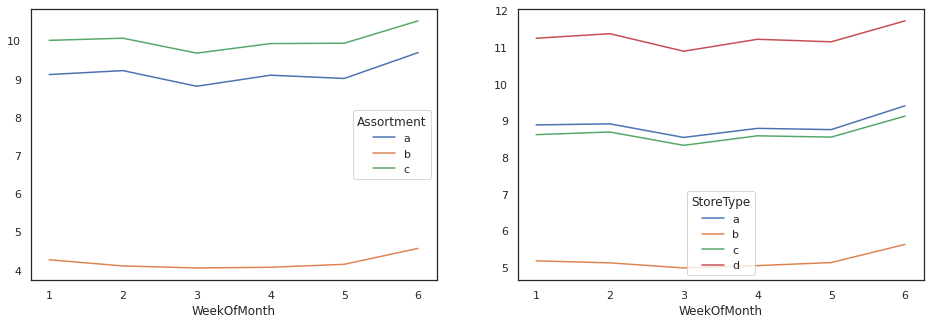

In [ ]:
assortment_pivot_ticket_medio_weekofmonth = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                     index='WeekOfMonth', 
                                                     values='TicketMedio', 
                                                     columns='Assortment', 
                                                     aggfunc=np.mean)

stype_pivot_ticket_medio_weekofmonth = pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                                                       index='WeekOfMonth', 
                                                       values='TicketMedio', 
                                                       columns='StoreType', 
                                                       aggfunc=np.mean)

graphs_to_plot = [
    assortment_pivot_ticket_medio_weekofmonth,
    stype_pivot_ticket_medio_weekofmonth,
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axe = axes.ravel()

for i, c in enumerate(graphs_to_plot):
    c.plot(ax=axe[i])

#Em relação à análise anterior, estes gráficos demonstram como o ticket-médio por tipo de produto vendido possui 
#desempenho diferente ao longo da semana de cada mês de um ano específico.

Tendo explorado de maneira significativa o comportamento das vendas, podemos passar a analisar estatisticamente os dados, validando algumas suposições e decidindo os tratamentos adequados para melhorar a performance do modelo.

In [ ]:
from scipy.stats import ttest_1samp
import statistics
from scipy import stats

total_sales = merged_sales['Sales']
all_data_mean = statistics.mean(total_sales)
std_dev = statistics.stdev(total_sales)
store_types = ["a", "b", "c", "d"]

confidence_level = 0.95
d = []

for stype in store_types:  

  t, p = ttest_1samp(a=merged_sales[merged_sales['StoreType']==stype]["Sales"], 
                     popmean=all_data_mean,
                     alternative="two-sided")
  
 
  degrees_freedom = len(merged_sales[merged_sales['StoreType']==stype]["Sales"]) -1
  sample_mean = statistics.mean(merged_sales[merged_sales['StoreType']==stype]["Sales"])
  sample_standard_error = stats.sem(merged_sales[merged_sales['StoreType']==stype]["Sales"])

  confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

  d.append(
      {
          "StoreType" : stype,
          "Exp.PopMean" : all_data_mean,
          "SampleMean" : sample_mean,
          "t_value" : t,
          "p_value" : format(p, '.4f'),
          "DegOfFreedom" : degrees_freedom,
          "ConfIntMin" : confidence_interval[0],
          "ConfIntMax" : confidence_interval[1]  
      }
  )

comparativo_medias_df = pd.DataFrame(d)
comparativo_medias_df

#Esta tabela compara as médias de venda para cada tipo de loja e seus testes estatísticos (t_value, p_value).
#Ela demonstra que as diferentes lojas possuem, de fato, diferença entre si, demonstrado pela 
#significância estatística (p_value < 0.05) calculada.

#h0 = my = 6.955
#h1 = my != 6.955

#The null and alternative hypotheses both assume that the population distribution is normal, 
#and additionally assumes that the population standard deviation is known

#Um valor de p<0.05 significa dizer o mesmo que, para a hipótese nula, 
#a média das vendas da amostra difere daquela da população.

#Os gráficos abaixo demonstram isto graficamente.

,StoreType,Exp.PopMean,SampleMean,t_value,p_value,DegOfFreedom,ConfIntMin,ConfIntMax
0,a,6955.514291,6925.167661,-6.259282,0.0000,457076,6915.665220,6934.670103
1,b,6955.514291,10231.407505,79.243427,0.0000,15562,10150.377035,10312.437975
2,c,6955.514291,6932.512755,-2.668214,0.0076,112977,6915.616559,6949.408950
3,d,6955.514291,6822.141881,-26.537893,0.0000,258773,6812.291576,6831.992186


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


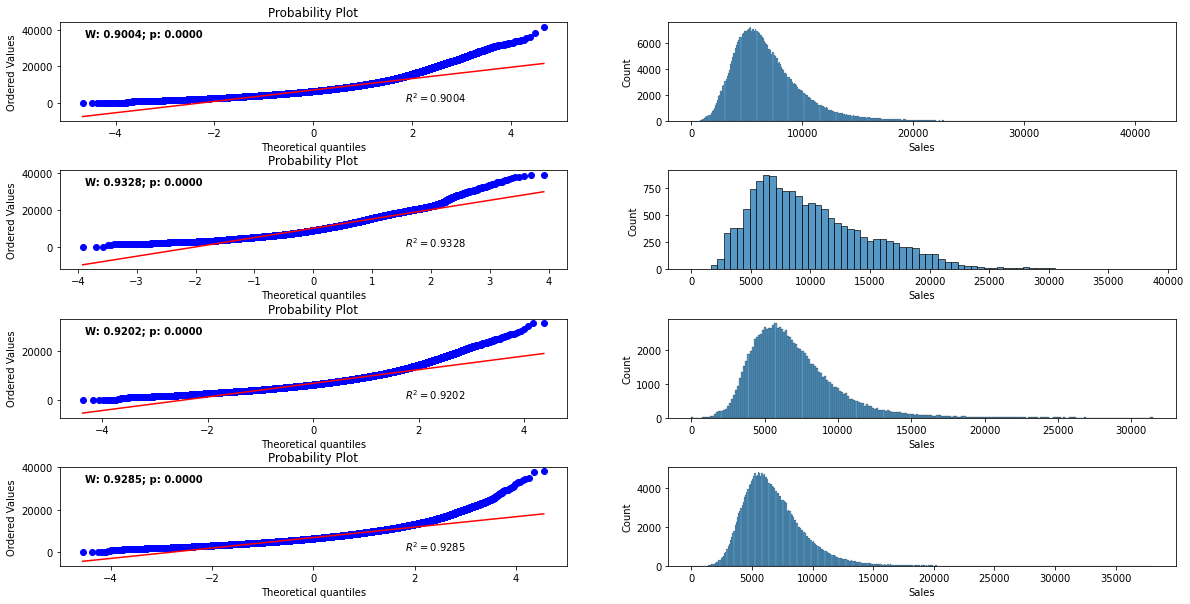

In [ ]:
import seaborn as sns
from scipy.stats import probplot
from scipy.stats import shapiro

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)

for stype, (ax1, ax2) in zip(store_types, axs):
    
    shapiros = shapiro(merged_sales[merged_sales['StoreType']==stype]["Sales"])
    
    qq = probplot(merged_sales[merged_sales['StoreType']==stype]["Sales"], 
                  dist ="norm", 
                  plot = ax1,
                  rvalue=True)
    
    plt.text(0.05, 0.85, "W: " + str(format(shapiros[0], '.4f')) + "; " + "p: " + str(format(shapiros[1], '.4f')), fontweight="bold", transform=ax1.transAxes)
       
    hist = sns.histplot(merged_sales[merged_sales['StoreType']==stype]["Sales"], ax=ax2)

Dado que p do teste de Shapiro-Wilk possui significância estatística (p<0.001), podemos assumir que as amostras de vendas por tipo de loja não são provenientes de uma distribuição normal; logo, são necessários testes **não-paramétricos**.

Wilcoxon test (also known as the Mann-Whitney test)

#h0 = my = 6.955
#h1 = my != 6.955

reject the null hypothesis when  V is very large or very small

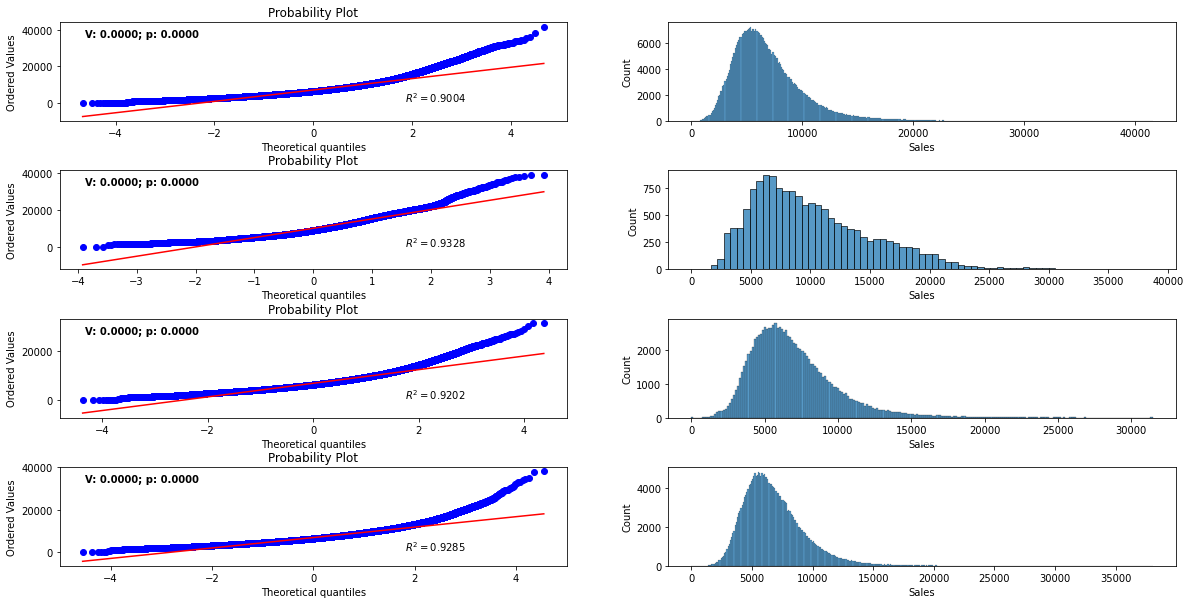

In [ ]:
from scipy.stats import wilcoxon

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)

for stype, (ax1, ax2) in zip(store_types, axs):
    
    wilcoxons = wilcoxon(merged_sales[merged_sales['StoreType']==stype]["Sales"])
    
    qq = probplot(merged_sales[merged_sales['StoreType']==stype]["Sales"], 
                  dist ="norm", 
                  plot = ax1,
                  rvalue=True)
    
    plt.text(0.05, 0.85, "V: " + str(format(wilcoxons[0], '.4f')) + "; " + "p: " + str(format(wilcoxons[1], '.4f')), fontweight="bold", transform=ax1.transAxes)
       
    hist = sns.histplot(merged_sales[merged_sales['StoreType']==stype]["Sales"], ax=ax2)

Nós evidenciamos, grafica e estatisticamente, que nossos dados não provém de uma distribuição normal.

A partir destas características, poderemos decidir as transformações necessárias para o(s) algoritmo(s) que formos utilizar posteriormente.

TRATAMENTO DOS DADOS

Primeiro, precisaremos tratar dos outliers. 

Depois, dado que possuímos dados faltantes e categorias interessantes que podem diferir o input (distância de competidor, tipo de loja e tipo de produto), sugerimos o uso do módulo imputer KNN.

O código a seguir demonstra como diferentes pré-processamentos atuam sob os dados.

COMPETITION DISTANCE

<AxesSubplot:ylabel='Frequency'>

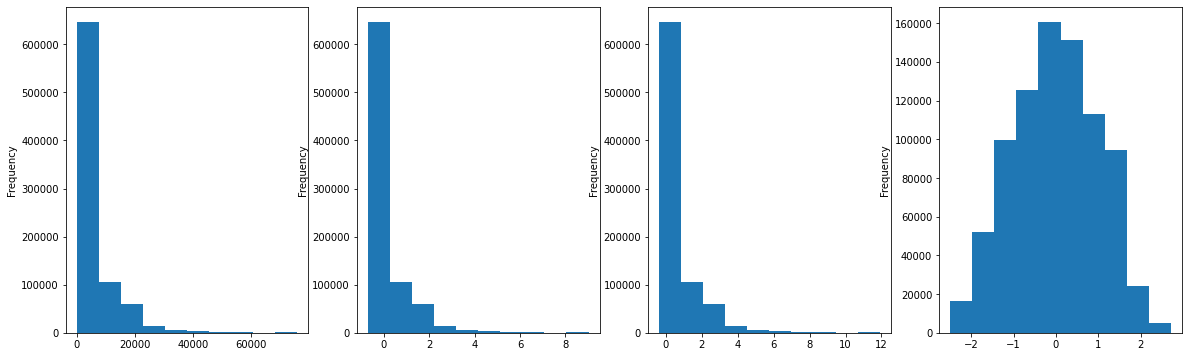

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
plt.subplots_adjust(hspace=0.5)

ct = ColumnTransformer([
         ('StdSc', StandardScaler(), ["CompetitionDistance"]),
         ('RobSc', RobustScaler(), ["CompetitionDistance"]),
         ('PwTr', PowerTransformer(method="box-cox"), ["CompetitionDistance"])
    ], remainder='passthrough').set_output(transform="pandas")

transformed_col = ct.fit_transform(merged_sales)

merged_sales["CompetitionDistance"].plot(ax=axes[0],
                                         kind="hist")

transformed_col["StdSc__CompetitionDistance"].plot(ax=axes[1],
                                                   kind="hist")

transformed_col["RobSc__CompetitionDistance"].plot(ax=axes[2],
                                                   kind="hist")

transformed_col["PwTr__CompetitionDistance"].plot(ax=axes[3],
                                                   kind="hist")

#Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. 
#This is useful for modeling issues related to heteroscedasticity (non-constant variance), 
#or other situations where normality is desired.

Uma vez que tratamos os dados, eliminarmos os efeitos dos outliers nos dados faltantes, portanto poderemos utilizar o método KNNImputer para preencher os NaNs.

In [ ]:
merged_sales.isna().sum()

Store                           0
DayOfWeek                       0
Sales                           0
Customers                       0
Open                            0
Promo                           0
StateHoliday                    0
SchoolHoliday                   0
StoreType                       0
Assortment                      0
CompetitionDistance          2186
CompetitionOpenSinceMonth       0
CompetitionOpenSinceYear        0
Promo2                          0
Promo2SinceWeek                 0
Promo2SinceYear                 0
Year                            0
Month                           0
DayOfMonth                      0
EndOfMonth                      0
StartOfMonth                    0
WeekOfMonth                     0
Log_Sales                       0
TicketMedio                     0
dtype: int64

In [ ]:
#Ao olharmos para os dados faltantes, nota-se que:
# - StateHoliday: em alguns tipos de produtos específicos para lojas em períodos específicos, não há venda
# - CompetitionOpenSinceMonth: 
# - CompetitionOpenSinceYear
# - Promo2SinceWeek
# - Promo2SinceYear
# - PromoInterval
# - TicketMedio
cols_with_nan = [col for col in merged_sales.columns if merged_sales[col].isna().any()]
cols_with_nan

['StateHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'TicketMedio']

In [ ]:
#Analisando NaN para StateHoliday
pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                index='StateHoliday', 
                values='Sales', 
                columns=['StoreType','Assortment', 'Year'], 
                aggfunc=np.median)

StoreType          a                                b                   \
Assortment         a               c                a                b   
Year            2013    2014    2013    2014     2013    2014     2013   
StateHoliday                                                             
0             5900.0  6116.0  6727.0  7074.0   9838.0  9621.0   6827.0   
a             6555.0  5940.0  3154.0  3370.5   9643.0  9591.0   9770.0   
b                NaN     NaN  2404.5  2503.5  10711.0  7746.5  10408.5   
c                NaN     NaN  4320.5  4160.0   5775.5  6498.0   9375.5   

StoreType                                     c                          \
Assortment                   c                a               c           
Year             2014     2013     2014    2013    2014    2013    2014   
StateHoliday                                                              
0              8544.0  17881.5  18203.0  6396.0  6656.0  6080.0  6653.5   
a             12254.0  18546.0  21501.0  7825.0  7465.0  7123.0  7092.0   
b             11296.5  20423.0  19480.5     NaN     NaN     NaN     NaN   
c             10754.5  15093.0  15563.5     NaN     NaN     NaN     NaN   

StoreType          d                          
Assortment         a               c          
Year            2013    2014    2013    2014  
StateHoliday                                  
0             5979.0  6243.0  6298.0  6844.0  
a             6707.0  5956.0  5397.0  5249.5  
b             3767.0  4286.0  2249.0  2743.5  
c                NaN     NaN     NaN  1800.0

In [ ]:
#Competition Open since month é resultado da presença ou não de um competidor aberto (desde que se tenha a informação)
#do ano em que o competidor abriu, logo, analisando-se um, entende-se o outro.

#Quando não há data para a abertura do competidor, NaN se transforma em 1900. É necessário encontrar uma maneira de 
#preencher estes dados faltantes adequadamente.

#Não podemos fazer uso de input pela média pois não faria sentido utilizar o ano médio de abertura (val min 1960, max 2015)
#para definir quando um determinado competidor abriu.

#Por isso, faremos uso da estratégia KNN (K-Nearest Neighbors)

pd.pivot_table((merged_sales[merged_sales['Year'] < 2015]), 
                index='CompetitionOpenSinceYear', 
                values='Sales',  
                aggfunc=np.median)

,Sales
CompetitionOpenSinceYear,
1900,8998.0
1961,7174.0
1990,6823.5
1994,6840.5
1995,6974.0
1998,7134.5
1999,5532.0
2000,7196.0
2001,5618.5


In [ ]:
#Optou-se por preencher PromoInterval com zero visto que a sua ausência significa que não há promoção ativa;
#Usou-se a data máxima para definir período das promoções, bem como de abertura do competidor.

merged_sales.loc[merged_sales['PromoInterval'].isna(), 'PromoInterval'] = 0
merged_sales.loc[merged_sales['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.datetime.now().year
merged_sales.loc[merged_sales['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.datetime.now().month
merged_sales.loc[merged_sales['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = merged_sales["Date"].max().year
merged_sales.loc[merged_sales['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = merged_sales["Date"].max().week

In [ ]:
#Para a variável StateHoliday, N/A na verdade significa que não há feriado na data; logo,
#preencher com Zero parece mais plausível.
merged_sales["StateHoliday"].unique(), merged_sales[merged_sales["StateHoliday"].isna()]["Sales"].sum()

(array(['0', 'a', 'b', 'c', nan], dtype=object), 751505326)

In [ ]:
merged_sales.loc[merged_sales['StateHoliday'].isna(), 'StateHoliday'] = 0
merged_sales[merged_sales["StateHoliday"].isna()]["Sales"].sum()

0

TICKET_MEDIO

In [ ]:
#Para os dados faltantes em TicketMedio, vemos que as vendas também são zero; logo, poderemos realizar o drop
merged_sales[merged_sales["TicketMedio"].isna()]["Sales"].sum()

0

In [ ]:
merged_sales.dropna(axis=0, subset=['TicketMedio'], inplace=True)
merged_sales[merged_sales["TicketMedio"].isna()].sum()

<ipython-input-30-6b02287e333a>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_sales[merged_sales["TicketMedio"].isna()].sum()


Store                        0.0
DayOfWeek                    0.0
Sales                        0.0
Customers                    0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
Year                         0.0
Month                        0.0
DayOfMonth                   0.0
WeekOfMonth                  0.0
EndOfMonth                   0.0
StartOfMonth                 0.0
TicketMedio                  0.0
dtype: float64

In [ ]:
def week_of_month(dt):
    """ Retorna o número da semana do mês da data especificada.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

n_splits = 2
tss = TimeSeriesSplit(n_splits=2)

merged_sales = train_data.merge(stores, 
                                how='left', 
                                on="Store", 
                                validate="many_to_one")

for col in merged_sales:
    if merged_sales[col].dtype == object:
        merged_sales[col] = merged_sales[col].str.strip()

merged_sales['Date'] = pd.to_datetime(merged_sales['Date'], format="%Y-%m-%d", errors='raise')
merged_sales["Year"] = merged_sales["Date"].dt.year
merged_sales["Month"] = merged_sales["Date"].dt.month
merged_sales["DayOfMonth"] = merged_sales["Date"].dt.day
merged_sales["EndOfMonth"] = merged_sales["Date"].dt.is_month_end
merged_sales["StartOfMonth"] = merged_sales["Date"].dt.is_month_start
merged_sales["WeekOfMonth"] = merged_sales["Date"].apply(week_of_month)
merged_sales.replace({True: 1, False: 0}, inplace=True)

merged_sales['CompetitionOpenSinceMonth'] = merged_sales['CompetitionOpenSinceMonth'].convert_dtypes()
merged_sales['CompetitionOpenSinceYear'] = merged_sales['CompetitionOpenSinceYear'].convert_dtypes()
merged_sales['Promo2SinceWeek'] = merged_sales['Promo2SinceWeek'].convert_dtypes()
merged_sales['Promo2SinceYear'] = merged_sales['Promo2SinceYear'].convert_dtypes()

merged_sales.drop(columns="PromoInterval", inplace=True)
merged_sales.loc[merged_sales['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.datetime.now().year
merged_sales.loc[merged_sales['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.datetime.now().month
merged_sales.loc[merged_sales['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = merged_sales["Date"].max().year
merged_sales.loc[merged_sales['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = merged_sales["Date"].max().week

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
merged_sales['CompetitionDistance'] = knn_imputer.fit_transform(merged_sales[['CompetitionDistance']])

merged_sales.loc[merged_sales['StateHoliday'].isna(), 'StateHoliday'] = str(0)
merged_sales.drop(index=(merged_sales[merged_sales["Open"] == 0]).index, axis=1, inplace=True)

merged_sales["Log_Sales"] = merged_sales["Sales"].map(lambda i: np.log(i) if i > 0 else 0)
merged_sales['TicketMedio'] = merged_sales['Sales'] / merged_sales['Customers']
merged_sales.dropna(axis=0, subset=['TicketMedio'], inplace=True)

merged_sales["MA_7_Customers"] = merged_sales.groupby(['Store', 'Date']).rolling(7)['Customers'].mean().reset_index(drop=True)
merged_sales["MA_14_Customers"] = merged_sales.groupby(['Store', 'Date']).rolling(14)['Customers'].mean().reset_index(drop=True)
merged_sales["MA_30_Customers"] = merged_sales.groupby(['Store', 'Date']).rolling(30)['Customers'].mean().reset_index(drop=True)

merged_sales["MA_7_Log_Sales"] = merged_sales.groupby(['Store', 'Date']).rolling(7)['Log_Sales'].mean().reset_index(drop=True)
merged_sales["MA_14_Log_Sales"] = merged_sales.groupby(['Store', 'Date']).rolling(14)['Log_Sales'].mean().reset_index(drop=True)
merged_sales["MA_30_Log_Sales"] = merged_sales.groupby(['Store', 'Date']).rolling(30)['Log_Sales'].mean().reset_index(drop=True)

merged_sales.set_index('Date', inplace=True)
merged_sales.sort_index(inplace=True)

X = merged_sales.loc[:, [col for col in merged_sales.columns if col not in ["Sales", "Log_Sales"]]]
X.replace([np.inf, -np.inf], np.nan, inplace=True)

y = merged_sales.loc[:, merged_sales.columns == "Log_Sales"]
y.replace([np.inf, -np.inf], np.nan).dropna(axis=1, inplace=True)

ct = ColumnTransformer(
    transformers=[
        ('StdSc', RobustScaler(), ['Customers']),
        ('PwrTr', PowerTransformer(), ["CompetitionDistance"]),
        ('MedImp', SimpleImputer(strategy='median'), ['TicketMedio', 'CompetitionDistance', 'MA_7_Customers', 'MA_14_Customers', 'MA_30_Customers', 'MA_7_Log_Sales', 'MA_14_Log_Sales', 'MA_30_Log_Sales' ]),
        ('Ohe', OneHotEncoder(), ['StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment'])
    ], remainder='passthrough')

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train, columns = ct.get_feature_names_out())
X_train_df.head()

,StdSc__Customers,PwrTr__CompetitionDistance,MedImp__TicketMedio,MedImp__CompetitionDistance,Ohe__StateHoliday_0,Ohe__StateHoliday_a,Ohe__StateHoliday_b,Ohe__StateHoliday_c,Ohe__SchoolHoliday_0,Ohe__SchoolHoliday_1,...,remainder__CompetitionOpenSinceYear,remainder__Promo2,remainder__Promo2SinceWeek,remainder__Promo2SinceYear,remainder__Year,remainder__Month,remainder__DayOfMonth,remainder__EndOfMonth,remainder__StartOfMonth,remainder__WeekOfMonth
0,1.954667,-0.736179,4.242705,720.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2002,0,31,2015,2013,1,1,0,1,1
1,-0.141333,-0.149856,6.817447,1870.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2011,0,31,2015,2013,1,1,0,1,1
2,2.058667,-1.415498,4.74446,210.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2023,0,31,2015,2013,1,1,0,1,1
3,5.874667,-0.439579,6.005913,1180.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2013,0,31,2015,2013,1,1,0,1,1
4,0.152,0.293109,4.255144,3640.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2023,1,10,2013,2013,1,1,0,1,1


FEATURE SELECTION

REDUÇÃO DO DIMENSIONAMENTO (DIMENSIONALITY REDUCTION)

A dimensionalidade trata do volume de variáveis explicativas que usamos em nosso modelo. Em outras palavras, com a sua redução, buscamos responder perguntas como: 

Conseguimos explicar o resultado (target) com menos variáveis? 
Qual é o ganho de informação (entropia) que o conjunto de variáveis explicativas nos oferece? 
Consigo economizar capacidade computacional ao realizar tal redução?

MUTUAL INFORMATION

The mutual information measures the reduction in uncertainty in variable A when variable B is known.

To select variables, we are interested in the mutual information between the predictor variables and the target. Higher mutual information values, indicate little uncertainty about the target Y given the predictor X.

Text(0, 0.5, 'Mutual Information')

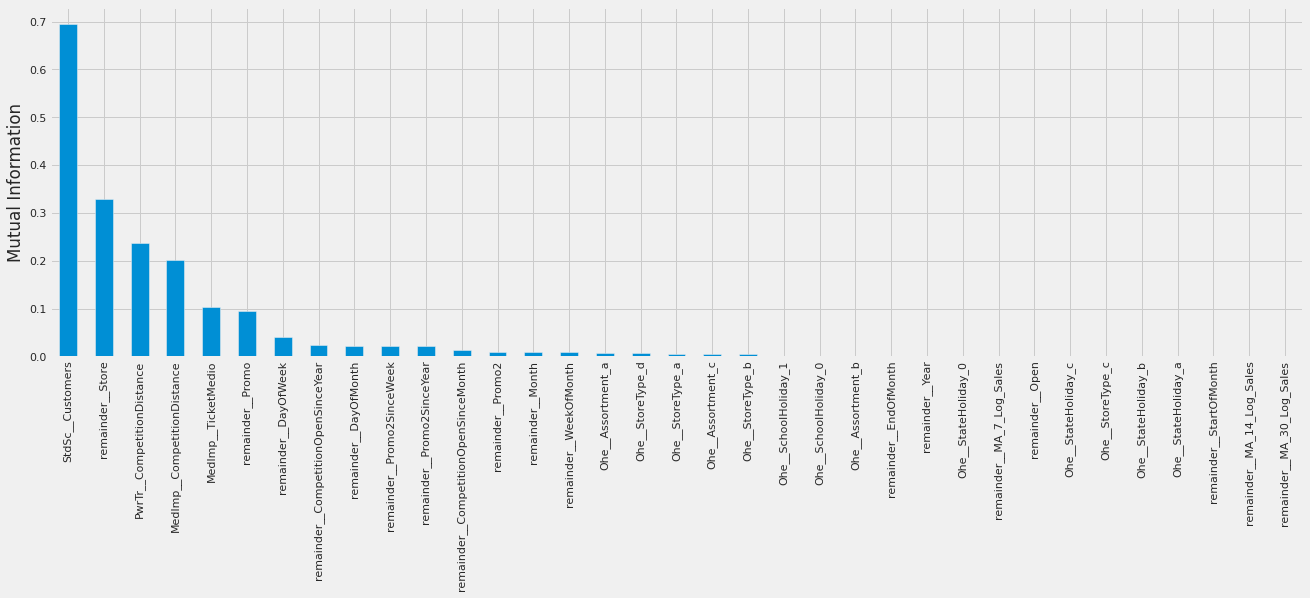

In [ ]:
mi = mutual_info_regression(X_train_df.fillna(0), y_train.values.ravel())

mi = pd.Series(mi)
mi.index = X_train_df.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

In [ ]:
# Select the features in the top percentile
sel_ = SelectPercentile(mutual_info_regression, percentile=20).fit(X_train_df.fillna(0), y_train.values.ravel())
X_train_selected = sel_.transform(X_train_df.fillna(0))
X_test_selected = sel_.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectPercentile was fitted with feature names
  warnings.warn(


In [ ]:
sel_.get_feature_names_out()

array(['StdSc__Customers', 'PwrTr__CompetitionDistance',
       'MedImp__TicketMedio', 'MedImp__CompetitionDistance',
       'remainder__Store', 'remainder__DayOfWeek', 'remainder__Promo'],
      dtype=object)

MODEL ASSUMPTIONS


Linear relationship: Relationship between response and feature variables should be linear. The linearity assumption can be tested using scatter plots. 

In [ ]:
merged_sales.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'DayOfMonth', 'EndOfMonth',
       'StartOfMonth', 'WeekOfMonth', 'Log_Sales', 'TicketMedio',
       'MA_7_Customers', 'MA_14_Customers', 'MA_30_Customers',
       'MA_7_Log_Sales', 'MA_14_Log_Sales', 'MA_30_Log_Sales'],
      dtype='object')

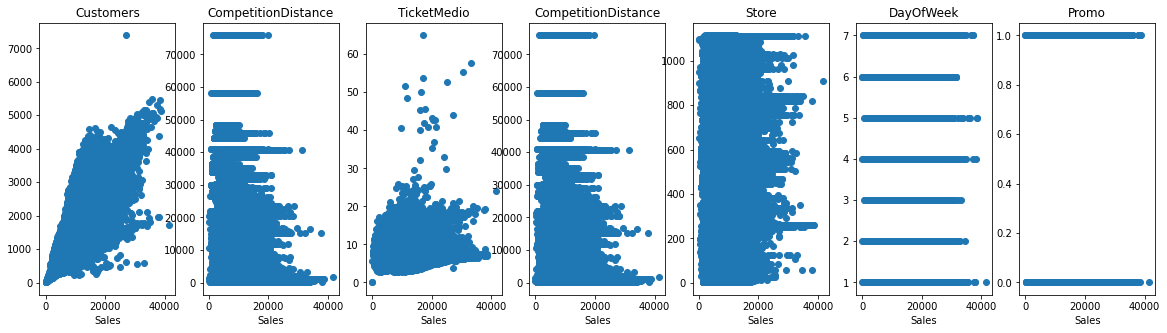

In [ ]:
cols = ['Customers', 'CompetitionDistance', 'TicketMedio', 'CompetitionDistance', 'Store', 'DayOfWeek', 'Promo']
fig, ax = plt.subplots(1, len(cols), figsize = (20, 5))
plt.subplots_adjust(hspace=0.5)

for idx, col in enumerate(cols, 0):
    ax[idx].plot(merged_sales['Sales'], merged_sales[col], 'o')
    ax[idx].set_xlabel('Sales')
    ax[idx].set_title(col)

plt.show()

#Através dos gráficos de dispersão conseguimos facilmente validar que as nossas variáveis não possuem relacionamento
#linear com a variável venda para a maior parte dos casos.

#Isso significa dizer que, em um cenário prático de projeto de Ciência de Dados, teríamos
#que lidar com um modelo não-linear.

Little or no multi-collinearity: It is assumed that there is little or no multicollinearity in the data. Multicollinearity occurs when the features (or independent variables) are not independent of each other.

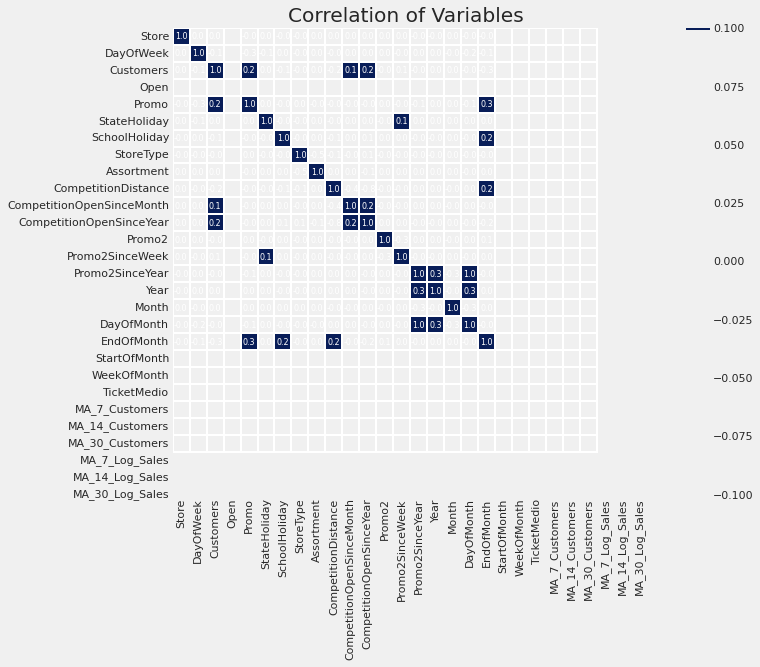

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(X.corr(), 
            xticklabels=X.columns, 
            yticklabels=X.columns, 
            center=0, 
            cmap="YlGnBu",
            vmin=X.corr().values.min(),
            vmax=1,
            square=True,
            linewidths=0.05,
            annot_kws={"fontsize":8},
            annot=True,
            fmt='.1f')
plt.title('Correlation of Variables')
plt.show()

#Nosso gráfico demonstra que não há multicolinearidade entre variáveis, que é atestado pelo exemplo na
#célula seguinte.

In [ ]:
# remove correlated features to reduce the feature space

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(pd.DataFrame(X_train), 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  0


APLICAÇÃO DO MODELO

Abaixo comparo o desempenho do modelo com todas as features versus com a seleção feita através do método Mutual Information.

Nota-se que o score de 0.83 x 0.85 justifica a redução de dimensionalidade, ao passo que se consegue explicar a variação dos dados a partir de um modelo enxuto (7 variáveis).

coefficient of determination: 0.8593197931092185
Variance score: 0.8631209519708136


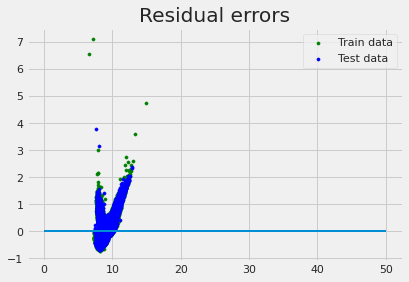

In [ ]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression().fit(X_train, y_train)
r_sq = lm_model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")

y_pred = lm_model.predict(X_train)
print('Variance score: {}'.format(lm_model.score(X_test, y_test)))

plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(lm_model.predict(X_train), lm_model.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(lm_model.predict(X_test), lm_model.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()

coefficient of determination: 0.8330396616746193
Variance score: 0.8333837636201578


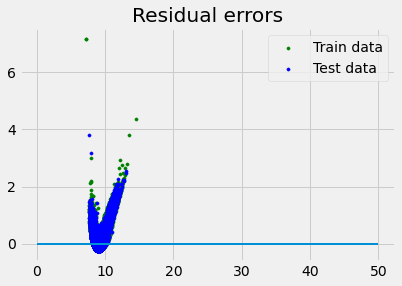

In [ ]:
lm_model = LinearRegression().fit(X_train_selected, y_train)
r_sq = lm_model.score(X_train_selected, y_train)
print(f"coefficient of determination: {r_sq}")

y_pred = lm_model.predict(X_train_selected)
print('Variance score: {}'.format(lm_model.score(X_test_selected, y_test)))

plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(lm_model.predict(X_train_selected), lm_model.predict(X_train_selected) - y_train,
            color = "green", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(lm_model.predict(X_test_selected), lm_model.predict(X_test_selected) - y_test,
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()

Little or no auto-correlation: Another assumption is that there is little or no autocorrelation in the data. Autocorrelation occurs when the residual errors are not independent of each other.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

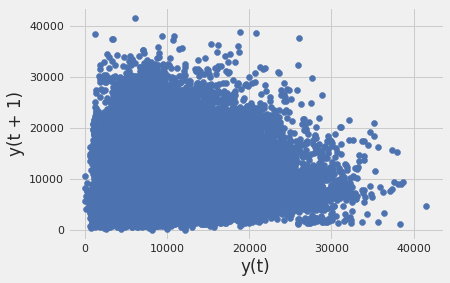

In [ ]:
# Podemos notar que esta premissa foi validada pelo gráfico a seguir, e, de apoio,
# a correlação com diferentes offsets (t+n)
pd.plotting.lag_plot(series=merged_sales["Sales"], 
                     lag=1)

In [ ]:
# extracting only the temperature values
values = pd.DataFrame(merged_sales["Sales"])
 
# using shift function to shift the values.
dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.244776  0.230143  0.229636
t+1  0.244776  1.000000  0.244778  0.230142
t+2  0.230143  0.244778  1.000000  0.244777
t+3  0.229636  0.230142  0.244777  1.000000


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

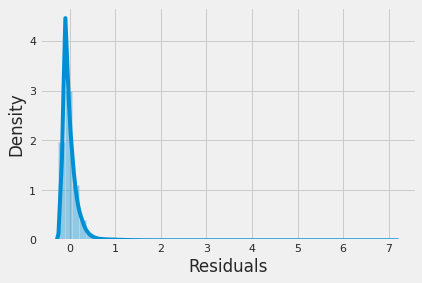

In [ ]:
residuals = y_pred - y_train
sns.distplot(residuals)
plt.xlabel('Residuals')

Homoscedasticity: Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent variables.

In [ ]:
import statsmodels.api as sm

X_ols = X_train_selected
y_ols = y_train
X_ols = sm.add_constant(X_ols)

model = sm.OLS(endog=y_ols, exog=X_ols)
results = model.fit()

bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)

print("Lagrange multiplier statistic: " + str(bp_lm))
print("Lagrange multiplier p-value:   " + str(bp_lm_pvalue))
print("F-statistic:                   " + str(bp_fvalue))
print("P-value of F-statistic:        " + str(bp_f_pvalue))

# If the p-value is less than the chosen significance level (e.g. 0.05), 
# reject the null hypothesis of homoscedasticity

#H0:The residuals are uniformly scattered. (No heteroskedasticity)
#HA:The residuals are not uniformly scattered. (Heteroskedasticity detected)

if bp_lm_pvalue < 0.05:
    print("Heteroscedasticity detected")
else:
    print("No heteroscedasticity detected")

Lagrange multiplier statistic: 53063.184997440345
Lagrange multiplier p-value:   0.0
F-statistic:                   8369.309714836972
P-value of F-statistic:        0.0
Heteroscedasticity detected


AVALIAÇÃO DO MODELO

In [ ]:
# (coefficient of determination) regression score function
#the proportion of the variation in the dependent variable that is predictable from the independent variable(s)
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=52)
n_scores = cross_val_score(lm_model, 
                           X=X_train_selected, 
                           y=y_train, 
                           scoring='r2', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report model performance
print('R2: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

R2: 0.833 (0.003)


In [ ]:
#Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors).
#Residuals are a measure of how far from the regression line data points are; 
#RMSE is a measure of how spread out these residuals are. 
#In other words, it tells you how concentrated the data is around the line of best fit.

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lm_model, 
                           X=X_train_selected, 
                           y=y_train, 
                           scoring='neg_root_mean_squared_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report model performance
print('neg_root_mean_squared_error: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

neg_root_mean_squared_error: -0.175 (0.002)


EXEMPLO

In [ ]:
cols = ['Customers', 'TicketMedio', 'CompetitionDistance', 'Store', 'DayOfWeek', 'Promo', 'Log_Sales']
merged_sales.loc['2013-01-01':'2013-01-01', [col for col in merged_sales.columns if col in cols]]

,Store,DayOfWeek,Customers,Promo,CompetitionDistance,Log_Sales,TicketMedio
Date,,,,,,,
2013-01-01,1097,2,1405,0,720.0,8.692994,4.242705
2013-01-01,85,2,619,0,1870.0,8.347590,6.817447
2013-01-01,259,2,1444,0,210.0,8.832150,4.744460
2013-01-01,262,2,2875,0,1180.0,9.756552,6.005913
2013-01-01,274,2,729,0,3640.0,8.039802,4.255144
2013-01-01,335,2,482,0,90.0,7.783641,4.981328
2013-01-01,353,2,820,0,900.0,8.051660,3.828049
2013-01-01,423,2,1751,0,1270.0,9.173988,5.507139
2013-01-01,948,2,1039,0,1430.0,8.409831,4.322425


In [ ]:
X_train_df[(X_train_df["remainder__Store"] == 1097) & 
             (X_train_df["remainder__DayOfWeek"] == 2)]["PwrTr__CompetitionDistance"][0]

-0.7361785330445021

In [ ]:
sel_.get_feature_names_out().tolist()

['StdSc__Customers',
 'PwrTr__CompetitionDistance',
 'MedImp__TicketMedio',
 'MedImp__CompetitionDistance',
 'remainder__Store',
 'remainder__DayOfWeek',
 'remainder__Promo']

In [ ]:
lm_model.predict([[12200,354,1234,-0.736179,1907,2,0]])

array([[4494.49612486]])